In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

from numpy.random import seed
seed(123)


2022-05-26 11:19:59.199885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 11:19:59.199950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1
2.9.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('https://raw.githubusercontent.com/przem85/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('https://raw.githubusercontent.com/przem85/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

/tmp/ipykernel_7766/1209707363.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('https://raw.githubusercontent.com/przem85/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.data', sep=", ",header = None)
/tmp/ipykernel_7766/1209707363.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('https://raw.githubusercontent.com/przem85/podstawy_sztucznej_inteligencji/main/Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=30, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

2022-05-26 11:20:09.323804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 11:20:09.324142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 11:20:09.324180: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hania-dell): /proc/driver/nvidia/version does not exist
2022-05-26 11:20:09.325875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
943/943 [==============================] - 4s 3ms/step - loss: 0.6434 - accuracy: 0.6421 - val_loss: 0.5484 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 2/30
943/943 [==============================] - 3s 3ms/step - loss: 0.5738 - accuracy: 0.7230 - val_loss: 0.5117 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 3/30
943/943 [==============================] - 3s 3ms/step - loss: 0.5222 - accuracy: 0.7489 - val_loss: 0.4481 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 4/30
943/943 [==============================] - 3s 3ms/step - loss: 0.4698 - accuracy: 0.7828 - val_loss: 0.4031 - val_accuracy: 0.8344 - lr: 1.0000e-04
Epoch 5/30
943/943 [==============================] - 3s 3ms/step - loss: 0.4376 - accuracy: 0.8035 - val_loss: 0.3830 - val_accuracy: 0.8369 - lr: 1.0000e-04
Epoch 6/30
943/943 [==============================] - 3s 3ms/step - loss: 0.4244 - accuracy: 0.8117 - val_loss: 0.3727 - val_accuracy: 0.8380 - lr: 1.0000e-04
Epoch 7/30
943/943 [==========================

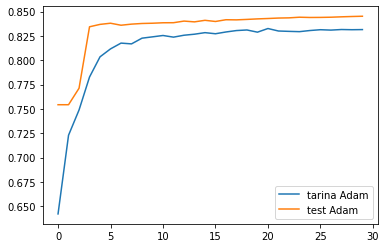

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

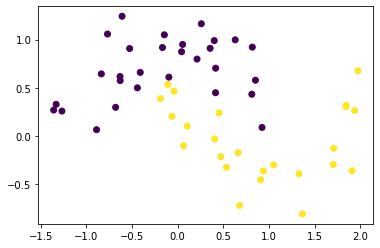

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=30, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              3000      
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 200)               100200    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 1s 183ms/step - loss: 0.8065 - accuracy: 0.4528 - val_loss: 0.8108 - val_accuracy: 0.4468
Epoch 2/30
2/2 [========================

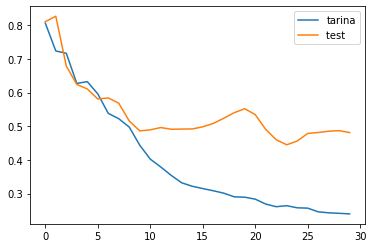

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

3888/3888 [==============================] - 10s 3ms/step


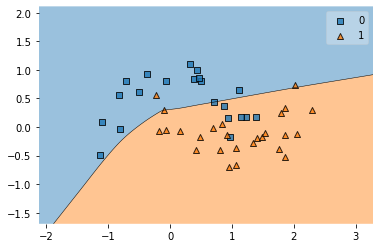

In [9]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [10]:
from keras.callbacks import History
from keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              3000      
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dense_10 (Dense)            (None, 200)               100200    
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 1s 205ms/step - loss: 0.7589 - accuracy: 0.5472 - val_loss: 0.7489 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [====================

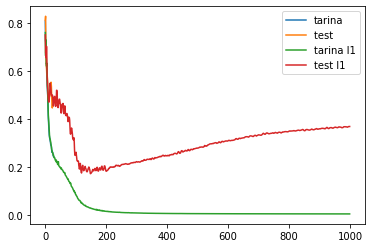

In [11]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

3888/3888 [==============================] - 9s 2ms/step


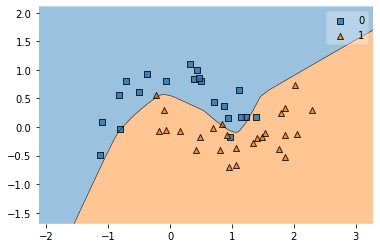

In [12]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()